In [70]:
#!pip install d2l==0.15.0


In [229]:
from d2l import torch as d2l
import numpy as np
import os
import math
import torch
from torch import nn

import cv2

import torchvision
from torchvision import transforms
from torchvision import datasets

from torch.utils import data
from torch.utils.data import Dataset,DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as F

from PIL import Image
import PIL.ImageOps  


In [230]:
img_folder_path = r'/Users/dmitryi/Documents/GitHub/data/images2'

In [231]:
class CustomDataSet(Dataset):
    def __init__(self, main_dir, transform):
        self.main_dir = main_dir
        self.transform = transform
        all_imgs = os.listdir(main_dir)
        self.total_imgs = sorted(all_imgs)

    def __len__(self):
        return len(self.total_imgs)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.total_imgs[idx])
        image = cv2.imread(img_loc, cv2.IMREAD_GRAYSCALE)
        th, inverted_image = cv2.threshold(image, 60, 255, cv2.THRESH_BINARY_INV)
        image2 = cv2.resize(inverted_image, (28,28))
        tensor_image = (self.transform(image2))#.unsqueeze(0)
        return tensor_image

In [232]:
# `ToTensor` converts the image data from PIL type to 32-bit floating point
# tensors. It divides all numbers by 255 so that all pixel values are between
# 0 and 1

trans = transforms.ToTensor()
mnist_train = torchvision.datasets.MNIST(
    root="../data", train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.MNIST(
    root="../data", train=False, transform=trans, download=True)

In [233]:
len(mnist_train), len(mnist_test)#, len(my_dataset)

(60000, 10000)

In [234]:
batch_size = 256

def get_dataloader_workers():  #@save
    """Use 4 processes to read the data."""
    return 4

train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True,
                             num_workers=get_dataloader_workers())

In [235]:
def load_data_mnist(batch_size, resize=None):  #@save
    """Download the MNIST dataset and then load it into memory."""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.MNIST(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.MNIST(
        root="../data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=get_dataloader_workers())
           )

In [236]:
batch_size = 256
train_iter, test_iter = load_data_mnist(batch_size)

In [237]:
# Посчитаем среднее по MNIST
mean = 0
std = 0

for images, _ in train_iter:
    batch_samples = images.size(0) # batch size (the last batch can have smaller size!)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)

mean /= len(train_iter.dataset)
std /= len(train_iter.dataset)

print('Mean = {}. Std = {}'.format(mean[0], std[0]))

Mean = 0.13066045939922333. Std = 0.30150434374809265


In [238]:
batch_size2=1
my_trans = transforms.Compose([transforms.ToTensor()#,
                               #transforms.Normalize((-0.0335), (0.8875))
                              ])

my_dataset = CustomDataSet(img_folder_path, transform=my_trans)
train_loader = data.DataLoader(my_dataset , batch_size=batch_size2, shuffle=False, 
                               num_workers=4, drop_last=True)

In [239]:
# Посчитаем среднее по моему Dataset
mean_dataset = 0
std_dataset = 0

for images in train_loader:
    print(images.size())
    batch_samples = images.size(0) # batch size (the last batch can have smaller size!)
    images = images.view(batch_samples, images.size(1), -1)
    mean_dataset += images.mean(2).sum(0)
    std_dataset += images.std(2).sum(0)

mean_dataset /= len(train_loader.dataset)
std_dataset /= len(train_loader.dataset)

print('Mean = {}. Std = {}'.format(mean_dataset[0], std_dataset[0]))

RuntimeError: DataLoader worker (pid(s) 9584) exited unexpectedly

## Initializing Model Parameters

In [240]:
class Reshape(torch.nn.Module):
    def forward(self, x):
        return x.view(-1, 1, 28, 28)

net = torch.nn.Sequential(
                            Reshape(),
                            nn.Conv2d(1, 6, kernel_size=3), 
                            nn.ReLU(),
                            nn.AvgPool2d(kernel_size=2, stride=2),
                            nn.Conv2d(6, 16, kernel_size=3), 
                            nn.ReLU(),
                            nn.AvgPool2d(kernel_size=2, stride=2),
                            nn.Flatten(),
                            nn.Linear(16 * 5 * 5, 120), 
                            nn.ReLU(),
                            nn.Linear(120, 84), 
                            nn.ReLU(),
                            nn.Linear(84, 10)
                        )

In [241]:
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)

Reshape output shape: 	 torch.Size([1, 1, 28, 28])
Conv2d output shape: 	 torch.Size([1, 6, 26, 26])
ReLU output shape: 	 torch.Size([1, 6, 26, 26])
AvgPool2d output shape: 	 torch.Size([1, 6, 13, 13])
Conv2d output shape: 	 torch.Size([1, 16, 11, 11])
ReLU output shape: 	 torch.Size([1, 16, 11, 11])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
ReLU output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
ReLU output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


## Training

In [242]:
def evaluate_accuracy_gpu(net, data_iter, device=None): #@save
    """Compute the accuracy for a model on a dataset using a GPU."""
    if isinstance(net, torch.nn.Module):
        net.eval()  # Set the model to evaluation mode
        if not device:
            device = next(iter(net.parameters())).device
    # No. of correct predictions, no. of predictions
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        if isinstance(X, list):
            # Required for BERT Fine-tuning (to be covered later)
            X = [x.to(device) for x in X]
        else:
            X = X.to(device)
        y = y.to(device)
        metric.add(d2l.accuracy(net(X), y), d2l.size(y))
    return metric[0] / metric[1]

In [243]:
def train_ch6(net, train_iter, test_iter, num_epochs, lr,
              device=d2l.try_gpu()):
    """Train a model with a GPU (defined in Chapter 6)."""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

loss 0.042, train acc 0.986, test acc 0.981
4588.1 examples/sec on cpu


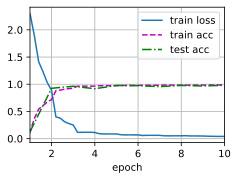

In [244]:
lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr)

Probability of 0 = 0.00 per cent
Probability of 1 = 0.01 per cent
Probability of 2 = 0.13 per cent
Probability of 3 = 0.00 per cent
Probability of 4 = 0.00 per cent
Probability of 5 = 0.00 per cent
Probability of 6 = 0.00 per cent
Probability of 7 = 99.86 per cent
Probability of 8 = 0.00 per cent


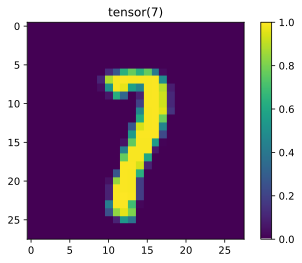

In [245]:
test_image = mnist_test[111][0][0]
net.eval()
with torch.no_grad():
    
    q=net.forward(test_image)
    pred = F.softmax(q, dim=-1)

    for i in range(9):
        print('Probability of %i = %.2f per cent' % (i, pred.squeeze()[i]*100))

    plt.imshow(test_image)
    plt.title(torch.argmax(pred))
    plt.colorbar()

Probability of 0 = 0.01 per cent
Probability of 1 = 0.00 per cent
Probability of 2 = 0.00 per cent
Probability of 3 = 0.34 per cent
Probability of 4 = 0.00 per cent
Probability of 5 = 99.59 per cent
Probability of 6 = 0.02 per cent
Probability of 7 = 0.00 per cent
Probability of 8 = 0.04 per cent


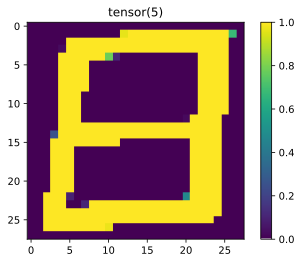

In [256]:
test_image = my_dataset[8][0]
net.eval()
with torch.no_grad():

    q=net.forward(test_image)
    pred = F.softmax(q, dim=-1)

    for i in range(9):
        print('Probability of %i = %.2f per cent' % (i, pred.squeeze()[i]*100))

    plt.imshow(test_image)
    plt.title(torch.argmax(pred))
    plt.colorbar()